In [13]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from analysis.dataset.june_dataset import JuNEDataset
from analysis.metrics.metrics_cells import CellsMetrics


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
path = Path("../data/all_data_06_09_2023.csv")
df_hack = pd.read_csv(path, index_col=0)
df_hack.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,NaN,NaN,NaN,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",NaN,student_7,False,NaN
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,"helper_functions,"
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,"helper_functions,"
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,"helper_functions,"
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,"helper_functions,"


In [15]:
june = JuNEDataset(df_hack)
june.prepare_dataset()
june.df.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label,task
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",None,student_7,False,None,task1
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,"helper_functions,",task1
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,"helper_functions,",task1
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,"helper_functions,",task1
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,"helper_functions,",task1


In [16]:
evolution_df = june.to_evolution_dataframe()
evolution_df


100%|██████████| 31/31 [00:28<00:00,  1.07it/s]


,state_num,cell_index,cell_num,cell_source,action_id,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,expert,cell_label,task
0,1,35c0b3b694f84140846a21197ea62f68,0.0,# # Do not forget to check if your notebook lo...,0.0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,student_7,False,None,task1
0,2,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,1.0,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1
0,3,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,2.0,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,code,"[{""output_type"":""stream"",""size"":23}]",student_7,False,"helper_functions,",task1
0,4,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,3.0,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1
0,5,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,4.0,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,code,"[{""output_type"":""stream"",""size"":23}]",student_7,False,"helper_functions,",task1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,497,dd4006fccad344ae8e13f2a49946b42e,14.0,"re.findall(r'[(]\S*', split2[0])[0].replace('(...",23053.0,2023-08-18 14:49:30.859,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,finished_execute,code,"[{""output_type"":""execute_result"",""size"":2661}]",expert_7,True,"comment_only,",task1
15,497,f372fcf1d6b9403587d8f226e65df63b,15.0,"re.findall(r'\S*[d+:]\S*', split2[0])[0].repla...",23053.0,2023-08-18 14:49:30.859,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,finished_execute,code,"[{""output_type"":""execute_result"",""size"":2661}]",expert_7,True,"comment_only,",task1
16,497,795bf5ffdb9a4bdfa5f0ed2937ea16dd,16.0,"\n\nfor i in df.iloc[:1,0]:\n split1 = i.sp...",23053.0,2023-08-18 14:49:30.859,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,finished_execute,code,"[{""output_type"":""execute_result"",""size"":2661}]",expert_7,True,"comment_only,",task1
17,497,b5843c42fca14f1a86a780e0caaf704c,17.0,df_final = pd.DataFrame()\n\n\nfor i in df.ilo...,23053.0,2023-08-18 14:49:30.859,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,finished_execute,code,"[{""output_type"":""execute_result"",""size"":2661}]",expert_7,True,"comment_only,",task1


In [17]:
evolution_df.shape


(557623, 16)

In [18]:
mask = (
    evolution_df.event.isin(["execute", "create", "delete"])
)
evolution_df[mask].head()


,state_num,cell_index,cell_num,cell_source,action_id,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,expert,cell_label,task
0,2,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,1.0,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1
0,4,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,3.0,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1
0,6,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,5.0,2023-05-06 10:33:01.263,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1
0,7,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,6.0,2023-05-06 10:33:06.253,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1
0,9,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,8.0,2023-05-06 10:33:09.812,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1


In [19]:
processor = CellsMetrics()

df_tmp = evolution_df[mask]
df_tmp['event'] = 'execute'

df_analysis = processor.calculate_cell_metrics(df_tmp.iloc[:])
df_analysis.head()


/var/folders/jq/byk1x73j6pngqgl6my8tgyhm0000gn/T/ipykernel_3694/935329659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['event'] = 'execute'
238071it [00:36, 5338.25it/s] <unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
238606it [00:36, 5311.18it/s]<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13: SyntaxWarning: invalid decimal literal
<unknown>:13:

,state_num,cell_index,cell_num,cell_source,action_id,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,expert,cell_label,task,objects,sloc,ccn
0,2,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,1.0,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1,1,2,1
1,4,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,3.0,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1,1,2,1
2,6,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,5.0,2023-05-06 10:33:01.263,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1,1,2,1
3,7,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,6.0,2023-05-06 10:33:06.253,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1,1,2,1
4,9,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,8.0,2023-05-06 10:33:09.812,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1,1,2,1


In [20]:
def continuous_transform(x, y, size: int = 1000, normalize: bool = True) -> tuple[np.ndarray, np.ndarray]:
    x_max = 1 if normalize else np.max(x)
    xp = np.linspace(0, x_max, size)
    x = np.linspace(0, x_max, len(y))
    y = np.array(y)

    y[np.isnan(y)] = 0
    y = np.interp(xp, x, y) + 1e-5
    return xp, y


In [21]:
df_analysis

,state_num,cell_index,cell_num,cell_source,action_id,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,expert,cell_label,task,objects,sloc,ccn
0,2,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,1.0,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1,1,2,1
1,4,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,3.0,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1,1,2,1
2,6,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,5.0,2023-05-06 10:33:01.263,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1,1,2,1
3,7,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,6.0,2023-05-06 10:33:06.253,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1,1,2,1
4,9,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,8.0,2023-05-06 10:33:09.812,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,False,"helper_functions,",task1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285787,496,dd4006fccad344ae8e13f2a49946b42e,14.0,"re.findall(r'[(]\S*', split2[0])[0].replace('(...",23052.0,2023-08-18 14:49:30.838,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,execute,code,None,expert_7,True,"comment_only,",task1,2,1,1
285788,496,f372fcf1d6b9403587d8f226e65df63b,15.0,"re.findall(r'\S*[d+:]\S*', split2[0])[0].repla...",23052.0,2023-08-18 14:49:30.838,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,execute,code,None,expert_7,True,"comment_only,",task1,2,1,1
285789,496,795bf5ffdb9a4bdfa5f0ed2937ea16dd,16.0,"\n\nfor i in df.iloc[:1,0]:\n split1 = i.sp...",23052.0,2023-08-18 14:49:30.838,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,execute,code,None,expert_7,True,"comment_only,",task1,8,7,3
285790,496,b5843c42fca14f1a86a780e0caaf704c,17.0,df_final = pd.DataFrame()\n\n\nfor i in df.ilo...,23052.0,2023-08-18 14:49:30.838,275683a9-81a4-47d8-89f0-f4f3564106bb,b12216b9-46d7-486c-9fa9-21d843da13dc,task1.ipynb,execute,code,None,expert_7,True,"comment_only,",task1,14,11,3


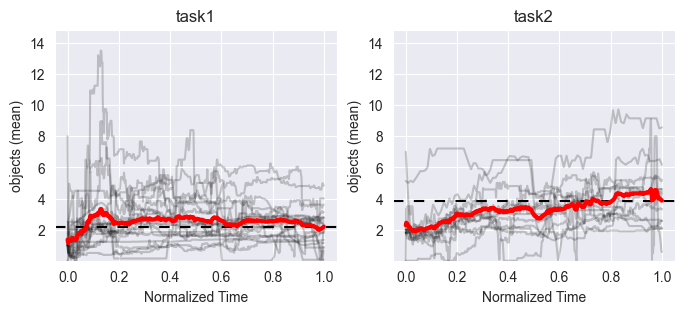

In [22]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
metric_name = 'objects'
aggregation_function = 'mean'
task_ax_mapping = {'task1': ax1, 'task2': ax2}
mean_curve = {'task1': [], 'task2': []}

df = df_analysis

size_threshold = 200
mn, mx = np.inf, -np.inf
for (task, kernel_id), g in df.groupby(['task', 'kernel_id']):
    if g.shape[0] < size_threshold:
        continue

    events_count = g.state_num.unique().shape[0]
    agg_fun_values = g.groupby("state_num")[metric_name].agg(aggregation_function)
    if agg_fun_values.iloc[:3].max() > 20:
        continue

    x, y = continuous_transform(
        np.arange(events_count), g.groupby("state_num")[metric_name].agg(aggregation_function),
        normalize=True
    )
    mean_curve[task].append(y)

    mn = y.min() if y.min() < mn else mn
    mx = y.max() if y.max() > mx else mx

    task_ax_mapping[task].plot(x, y, color='k', alpha=0.2)

for task, curves in mean_curve.items():
    y = np.sum(curves, axis=0) / len(curves)
    x = np.linspace(0, 1, len(y))

    task_ax_mapping[task].axhline(y[-1], color='k', ls=(0, (5, 5)))
    task_ax_mapping[task].plot(x, y, color='r', lw=3)

for task, ax in task_ax_mapping.items():
    ax.set_ylim(mn * 0.9, mx * 1.1)
    ax.set_xlabel('Normalized Time')
    ax.set_ylabel(f"{metric_name} ({aggregation_function})")
    ax.set_title(task.replace("_", " "))

plt.savefig(f"figures/evolution/{metric_name}_{aggregation_function}_tasks.pdf", dpi=300, bbox_inches='tight')


In [23]:
import itertools

df_tmp = df.groupby(['kernel_id', 'state_num'])[['sloc', 'ccn', 'objects']] \
    .agg(['mean', 'sum']).reset_index()

df_tmp = df_tmp.loc[df_tmp.groupby('kernel_id').state_num.idxmax()].set_index("kernel_id")
df_tmp['task'] = df_analysis[['task', 'kernel_id']] \
    .drop_duplicates(keep='last').set_index('kernel_id')['task']

df_tmp['expert'] = june.df[['expert', 'kernel_id']] \
    .drop_duplicates(keep='last').set_index('kernel_id')['expert']

df_tmp = df_tmp.reset_index()

cols = list(itertools.product(['sloc', 'ccn', 'objects'], ['mean', 'sum'], ['mean']))
table = df_tmp.drop('state_num', axis=1).groupby(["task", "expert"]).describe().loc[:, cols]
table.round(2)


/var/folders/jq/byk1x73j6pngqgl6my8tgyhm0000gn/T/ipykernel_3694/3585123997.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  table = df_tmp.drop('state_num', axis=1).groupby(["task", "expert"]).describe().loc[:, cols]


sloc           ccn        objects        
              mean     sum  mean    sum    mean     sum
              mean    mean  mean   mean    mean    mean
task  expert                                           
task1 False   2.41   87.21  1.01  44.43    2.01   81.00
      True    2.76   73.60  1.07  26.60    2.73   72.40
task2 False   4.81  114.00  0.98  22.67    4.51   99.00
      True    2.43   80.17  0.85  28.17    3.22  101.67

In [24]:
print(table.round(2).applymap('{:.2f}'.format).to_latex(escape=True, multirow=True))


\begin{tabular}{llllllll}
\toprule
 &  & \multicolumn{2}{r}{sloc} & \multicolumn{2}{r}{ccn} & \multicolumn{2}{r}{objects} \\
 &  & mean & sum & mean & sum & mean & sum \\
 &  & mean & mean & mean & mean & mean & mean \\
task & expert &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{task1} & False & 2.41 & 87.21 & 1.01 & 44.43 & 2.01 & 81.00 \\
 & True & 2.76 & 73.60 & 1.07 & 26.60 & 2.73 & 72.40 \\
\cline{1-8}
\multirow[t]{2}{*}{task2} & False & 4.81 & 114.00 & 0.98 & 22.67 & 4.51 & 99.00 \\
 & True & 2.43 & 80.17 & 0.85 & 28.17 & 3.22 & 101.67 \\
\cline{1-8}
\bottomrule
\end{tabular}



In [29]:
df_tmp = df_analysis.groupby(['kernel_id', 'state_num'])[['sloc', 'ccn', 'objects']] \
    .agg(['mean', 'sum']).reset_index()
df_tmp.columns = ['_'.join(col).strip("_") for col in df_tmp.columns.values]

# df_tmp.merge(df_analysis[['task','kernel_id']].drop_duplicates(keep='last')[['kernel_id', 'task']], on='kernel_id', how='left')
df_tmp = pd.merge(
    df_tmp,
    df_analysis[['task', 'kernel_id']] \
        .drop_duplicates(keep='last')[['kernel_id', 'task']],
    on='kernel_id'
)

df_tmp = pd.merge(
    df_tmp,
    june.df[['expert', 'kernel_id']] \
        .drop_duplicates(keep='last')[['kernel_id', 'expert']],
    on='kernel_id'
)

max_values = df_tmp.groupby('kernel_id')['state_num'].transform('max')
df_tmp['normalized_state'] = df_tmp['state_num'] / max_values

metrics_list = list(df_tmp)[2:-3]

df_corr = df_tmp.groupby(['task', 'expert'])[['normalized_state', *metrics_list]].corr()
indices = [i for i in df_corr.index if i[-1] == 'normalized_state']
df_corr[metrics_list] = df_corr[metrics_list]

table = df_corr.loc[indices][metrics_list]
table.round(3)


sloc_mean  sloc_sum  ccn_mean  ccn_sum  \
task  expert                                                            
task1 False  normalized_state     -0.141     0.483    -0.106    0.413   
      True   normalized_state      0.071     0.684    -0.122    0.608   
task2 False  normalized_state      0.442     0.525     0.188    0.498   
      True   normalized_state      0.114     0.536    -0.015    0.513   

                               objects_mean  objects_sum  
task  expert                                              
task1 False  normalized_state        -0.083        0.526  
      True   normalized_state         0.153        0.704  
task2 False  normalized_state         0.555        0.596  
      True   normalized_state         0.471        0.660

In [26]:
print(table.round(2).applymap('{:.2f}'.format).to_latex(escape=True, multirow=True))


\begin{tabular}{lllllllll}
\toprule
 &  &  & sloc\_mean & sloc\_sum & ccn\_mean & ccn\_sum & objects\_mean & objects\_sum \\
task & expert &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{task1} & False & normalized\_state & -0.14 & 0.48 & -0.11 & 0.41 & -0.08 & 0.53 \\
\cline{2-9}
 & True & normalized\_state & 0.07 & 0.68 & -0.12 & 0.61 & 0.15 & 0.70 \\
\cline{1-9} \cline{2-9}
\multirow[t]{2}{*}{task2} & False & normalized\_state & 0.44 & 0.52 & 0.19 & 0.50 & 0.56 & 0.60 \\
\cline{2-9}
 & True & normalized\_state & 0.11 & 0.54 & -0.02 & 0.51 & 0.47 & 0.66 \\
\cline{1-9} \cline{2-9}
\bottomrule
\end{tabular}



In [48]:
import pingouin as pg

alpha = 0.05
for task in ['task1', 'task2']:
    for expert in [True, False]:
        for metric in metrics_list:
            df_sample = df_tmp[(df_tmp.task == task) & (df_tmp.expert == expert)][['normalized_state', metric]]
            cor = pg.corr(df_sample.normalized_state, df_sample[metric])
            if cor['p-val'].iloc[0] > alpha:
                print(metric, task, expert, cor['r'].iloc[0].round(2), cor['p-val'].iloc[0].round(2))


ccn_mean task2 True -0.02 0.41
